In [101]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

# https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [102]:
debut = '2019-01-04 12:55:00'
fin = '2019-03-02 12:55:00'

:00 ---- 2019-01-16 11:40:00
 
 EUR/USD   a un kmo donsidéré comme   inadéquat 
 AUD/USD   a un kmo donsidéré comme   inadéquat 
 CHF/USD   a un kmo donsidéré comme   inadéquat 
 GBP/USD   a un kmo donsidéré comme   inadéquat 
 JPY/USD   a un kmo considéré comme   adéquat 
AUD/USD  :  0.8133920506638622
CHF/USD  :  0.5800590806997301
GBP/USD  :  -0.24486680359118893
JPY/USD  :  49.563084314194306
Test   VALIDE   avec un score de   88.41  %
Les poids respectifs sont de :
AUD/USD  :  0.8133920506638622
CHF/USD  :  0.5800590806997301
GBP/USD  :  -0.24486680359118893
JPY/USD  :  49.563084314194306
Et la constante est :   -0.1704578502525531 
Le test est   VALIDE  et le résidu est :   STATIONNAIRE 
Le test est   VALIDE  et il y a :   RETOUR A LA MOYENNE 


TAILLES DES POSITIONS :
EUR/USD :  100000
AUD/USD :  81339.20506638622
CHF/USD :  58005.90806997301
GBP/USD :  -24486.68035911889
JPY/USD :  4956308.43141943


   A C T I O N  


Date :  2019-01-14 11:40:00
 ACTION OPEN LONG  Niveau 1  - 

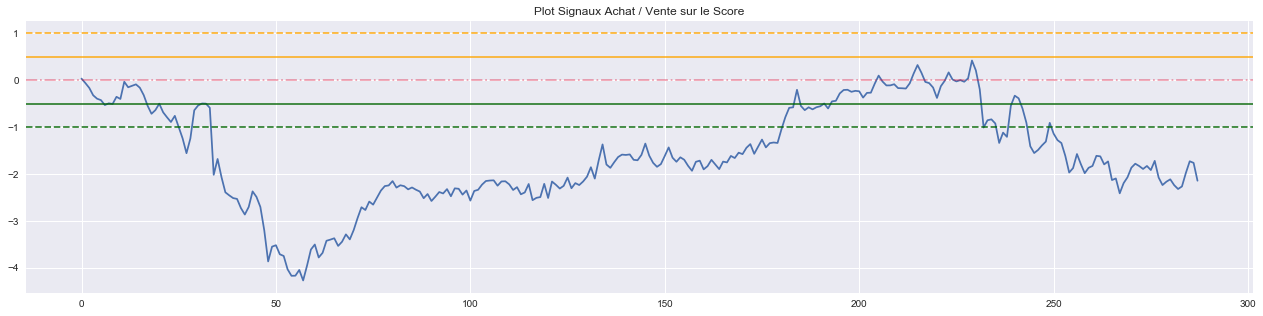

In [103]:
%%time
############################
######## LIBRAIRIES ########
############################
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johasen
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import numpy as np
%matplotlib inline
plt.style.use('seaborn')

############################
######## FONCTIONS ########
###########################
name = ''
def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()

    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    if p_value <= 0.05:
        stop = 0
    else:
        stop = 1
    return(stop)

def skewness(df):
    if skew < -0.1 or skew > 0.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def kurtos(df):
    if kurtosis > -3.1 or kurtosis < 3.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor(df):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor_diff(diff):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        p = 1
    else:
        stop = 1
    return()

def test_stationarity(timeseries,lag):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #orig = plt.plot(timeseries, color='blue',label='Original')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

def test_adf(df):
    X = df['Close'].values
    result_adf = adfuller(X)
    
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        stop = 1
    else:
        stop = 0
        
    X = diff[1:].values
    result_adf = adfuller(X)
    
    if result_adf[1] >= 0.05 :
        stop = 1

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        stop = 1

    else:
        stop = 0
    return(stop)

def isname(pair):
    global name
    if pair.equals(eurusd):
        name = 'EUR/USD'
    elif pair.equals(audusd):
        name = 'AUD/USD'
    elif pair.equals(chfusd):
        name = 'CHF/USD'
    elif pair.equals(gbpusd):
        name = 'GBP/USD'
    elif pair.equals(jpyusd):
        name = 'JPY/USD'
    
    return(name)

def revname(name):
    if name == 'EUR/USD':
        pair = eurusd
    elif name == 'AUD/USD':
        pair = audusd
    elif name == 'CHF/USD':
        pair = chfusd
    elif name == 'GBP/USD':
        pair = gbpusd
    elif name == 'JPY/USD':
        pair = jpyusd
        
    return(pair)

def transform():
    df = pd.DataFrame()
    inv = 'NON'
    dfname = input('Entrez le nom du fichier à transformer (sans le .csv)')
    print('Parsing des dates. Cela peut prendre quelques minutes')
    df = pd.read_csv(dfname+'.csv',parse_dates=['Local time'])
    inv = input('Doit-on inverser les devises? (NON - OUI)')
    if inv == 'OUI' or inv == 'oui' or inv == 'o' or inv =='O':
        print('inversion des devises')
        df['Open'] = 1 / df['Open']
        df['High'] = 1 / df['High']
        df['Low'] = 1 / df['Low']
        df['Close'] = 1 / df['Close']
        df.to_csv(dfname+'_transformed.csv')
    else:
        df.to_csv(dfname+'_transformed.csv')
        
    print('Done pour ',dfname+'.csv')
    return()

base_eurusd = pd.read_csv('EURUSD.csv')
try:
    base_eurusd = base_eurusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_eurusd['Local time'] = pd.to_datetime(base_eurusd['Local time'])

base_audusd = pd.read_csv('AUDUSD.csv')

try:
    base_audusd = base_audusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_audusd['Local time'] = pd.to_datetime(base_audusd['Local time'])

base_chfusd = pd.read_csv('USDCHF.csv')
try:
    base_chfusd = base_chfusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_chfusd['Local time'] = pd.to_datetime(base_chfusd['Local time'])

base_gbpusd = pd.read_csv('GBPUSD.csv')

try:
    base_gbpusd = base_gbpusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_gbpusd['Local time'] = pd.to_datetime(base_gbpusd['Local time'])

base_jpyusd = pd.read_csv('USDJPY.csv')

try:
    base_jpyusd = base_jpyusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_jpyusd['Local time'] = pd.to_datetime(base_jpyusd['Local time'])


print('Vérification des longueur de bases (',base_eurusd.shape[0],') :')

if base_eurusd.shape[0] != base_audusd.shape[0] or base_eurusd.shape[0] != base_chfusd.shape[0] \
or base_eurusd.shape[0] != base_gbpusd.shape[0] or base_eurusd.shape[0] != base_jpyusd.shape[0] :
    print(Fore.RED,'=================== > NON VALIDE',Style.RESET_ALL)

else:
    print(Fore.GREEN,'========================= > VALIDE',Style.RESET_ALL)
    
print('\nEUR/USD : ')
print('Début : ',base_eurusd.iloc[0]['Local time'])
print('Fin : ',base_eurusd.iloc[-1]['Local time'])
print('Shape : ',base_eurusd.shape)

print('\nAUD/USD : ')
print('Début : ',base_audusd.iloc[0]['Local time'])
print('Fin : ',base_audusd.iloc[-1]['Local time'])
print('Shape : ',base_audusd.shape)

print('\nCHF/USD : ')
print('Début : ',base_chfusd.iloc[0]['Local time'])
print('Fin : ',base_chfusd.iloc[-1]['Local time'])
print('Shape : ',base_chfusd.shape)

print('\nGBP/USD : ')
print('Début : ',base_gbpusd.iloc[0]['Local time'])
print('Fin : ',base_gbpusd.iloc[-1]['Local time'])
print('Shape : ',base_gbpusd.shape)

print('\nJPY/USD : ')
print('Début : ',base_jpyusd.iloc[0]['Local time'])
print('Fin : ',base_jpyusd.iloc[-1]['Local time'])
print('Shape : ',base_jpyusd.shape)

print('\nPremière date : ',base_eurusd.iloc[0]['Local time'],['Local time'])
print('\nDernière date : ',base_eurusd.iloc[-1]['Local time'],['Local time'],'\n')


stop = 0
nb_jour = 7
diloug = nb_jour * 288

os,cs,ol,cl = 0,0,0,0

mise = 100000
profit_long = 0
profit_short = 0
profit = 0
nbre_trade = 0
nbre_trade_long = 0
nbre_trade_short = 0
pnls = 0
pnll = 0

buy1 = 0
buy2 = 0
buy3 = 0
sell1 = 0
sell2 = 0
sell3 = 0
nbposl= 0
nbposs = 0

OS = []
OL = []
CL = []
CS = []
SELL1 = []
SELL2 = []
SELL3 = []
BUY1 = []
BUY2 = []
BUY3 = []
NBPOSS = []
NBPOSL = []
TIME = []
SCORE = []
CSTE = []

TIME_FRAME = base_audusd[(base_audusd['Local time']>=debut)&(base_audusd['Local time']<=fin)]['Local time'].to_list()
sorted(TIME_FRAME)


for step in range(0,288):
    try:
        print(Fore.MAGENTA,'')
        print('Step : ',step,' Ind : ',diloug,' --- ',TIME_FRAME[step],'----',TIME_FRAME[step+diloug-576],'----', TIME_FRAME[step+diloug])
        print(Style.RESET_ALL,'')

        debut = TIME_FRAME[step]
        split = TIME_FRAME[step+diloug-576]
        fin = TIME_FRAME[step+diloug]

        eurusd = base_eurusd[(base_eurusd['Local time'] >= debut)&(base_eurusd['Local time'] <= split)]
        audusd = base_audusd[(base_audusd['Local time'] >= debut)&(base_audusd['Local time'] <= split)]
        chfusd = base_chfusd[(base_chfusd['Local time'] >= debut)&(base_chfusd['Local time'] <= split)]
        gbpusd = base_gbpusd[(base_gbpusd['Local time'] >= debut)&(base_gbpusd['Local time'] <= split)]
        jpyusd = base_jpyusd[(base_jpyusd['Local time'] >= debut)&(base_jpyusd['Local time'] <= split)]


        PAIR = [eurusd,audusd,chfusd,gbpusd,jpyusd]
        
        for pair in PAIR:

            name = isname(pair)

            model = sm.OLS(pair['Close'],pair.index)
            results = model.fit()
            residuals = results.resid
            summary = results.summary()

            jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

            jarque_berra(pair)
            skewness(pair)
            kurtos(pair)
            autocor(pair)
        df = pd.DataFrame()
        for pair in PAIR:
            name = isname(pair)
            df[name] = list(pair['Close'])
        df.corr().style.background_gradient(cmap='coolwarm')

        INTEGRE = []
        for col in range(1,len(df.corr())):
            for ind in range(col):
                if df.corr().iloc[ind,col] > 0.5 and df.corr().iloc[ind,col] != 1:
                    INTEGRE.append((df.corr().index[ind],df.corr().columns[col]))


        INTEGRE  = list(set(INTEGRE))

        kmo_all,kmo_model=calculate_kmo(df)

        for loop,pair in enumerate(PAIR):
            name = isname(pair)
            if kmo_all[loop] >= 0.6:
                print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquat',Style.RESET_ALL)
            else:
                print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)

        chi_square_value,p_value=calculate_bartlett_sphericity(df)
        if p_value < 0.05:
            stop = 0
        else:
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                #continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 386\n\n\n',Style.RESET_ALL)

        fa = FactorAnalyzer(rotation=None)
        fa.fit(df)
        
        ev, v = fa.get_eigenvalues()

        PRINCIPAL_COMPOSANT = []
        for loop,pair in enumerate(PAIR):
            name = isname(pair)
            if ev[loop] >= 1:
                PRINCIPAL_COMPOSANT.append((name,ev[loop]))

        jh_results = johasen(df,0,1)
        v1 = jh_results.evec[:, 0]
        v2 = jh_results.evec[:, 1]
        if jh_results.eig[0] <= 0.05:
            stop = 0
        else:
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                #continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 408\n\n\n',Style.RESET_ALL)

        X = df.iloc[:,1:]
        y = df.iloc[:,0]
        reg = LinearRegression().fit(X, y)
        score = reg.score(X, y) *100
        coef = reg.coef_
        cste = reg.intercept_
        CSTE.append(cste)

        if score > 70:
            stop = 0
            loop = -1
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        #continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 432\n\n\n',Style.RESET_ALL)

        elif score > 50:
            
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        #continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 448\n\n\n',Style.RESET_ALL)

        else:
            stop = 1
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        #continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 465\n\n\n',Style.RESET_ALL)

        combo = coef[0] * df['AUD/USD'] + coef[1] * df['CHF/USD'] + coef[2] * df['GBP/USD'] + coef[3] * df['JPY/USD'] + cste
        
        ########
        ### RESIDUS
        ########
        residu = df['EUR/USD']-combo
        S = (residu - residu.mean())/residu.std()
       
        ####
        ## ANALYSE DES RESIDUS
        ###

        jarque_berra(residu)
        skewness(residu)
        kurtos(residu)
        residu_autocor = pd.DataFrame()
        residu_autocor['Close'] = residu.iloc[:]
        autocor(residu_autocor)

        model = sm.OLS(residu,residu.index)
        results = model.fit()
        residuals = results.resid
        summary = results.summary()
        name = 'Analyse des Résidus'
        jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

        dfoutput =  test_stationarity(residu,lag = 1)
        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            #print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
            stop = 0
        else:
            #print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                #continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 501\n\n\n',Style.RESET_ALL)

        #######
        ### RETOUR A LA MOYENNE
        #######
        dfoutput =  test_stationarity(residu,lag = 0)

        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            #print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 0
        else:
            #print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                #continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 516\n\n\n',Style.RESET_ALL)


        chi_square_value,p_value=calculate_bartlett_sphericity(df)
        if p_value < 0.05:
            #print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
            pass
        else:
            #print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )
            pass

        fa = FactorAnalyzer(rotation=None)
        fa.fit(df)
        
        ev, v = fa.get_eigenvalues()


        
        pca = PCA(n_components=2)
        pca.fit(df)

        x_pca = pca.transform(df)
        x_pca.shape


        for loop,pair in enumerate(PAIR):
            name = isname(pair)

        jh_results = johasen(df,0,1)
        
        v1 = jh_results.evec[:, 0]
        v2 = jh_results.evec[:, 1]

        if jh_results.eig[0] <= 0.05:
            #print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
            pass
        else:
            #print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)
            pass

        X = df.iloc[:,1:]
        y = df.iloc[:,0]
        reg = LinearRegression().fit(X, y)
        score = reg.score(X, y) *100
        coef = reg.coef_
        cste = reg.intercept_

        if score > 70:
            print('Test ',Fore.GREEN,'VALIDE',Style.RESET_ALL,' avec un score de ',Fore.GREEN,round(score,2),Style.RESET_ALL,'%')
            print("Les poids respectifs sont de :")
            loop = -1
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    print(name,' : ',Fore.RED,'NON VALIDE',Style.RESET_ALL)
            print('Et la constante est : ',Fore.GREEN,cste,Style.RESET_ALL)

        elif score > 50:
            print('Test ',Fore.YELLOW,'MITIGE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,round(score,2),Style.RESET_ALL,'%')
            print("Les poids respectifs sont de :")
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    print(name,' : ',Fore.RED,'NON VALIDE',Style.RESET_ALL)
            print('Et la constante est : ',Fore.GREEN,cste,Style.RESET_ALL)

        else:
            print('Test ',Fore.RED,'NON VALIDE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,round(score,2),Style.RESET_ALL,'%')
            print("Les poids respectifs sont de :")
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    print(name,' : ',Fore.RED,'NON VALIDE',Style.RESET_ALL)
            print('Et la constante est : ',Fore.GREEN,cste,Style.RESET_ALL)
            #continue
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 607\n\n\n',Style.RESET_ALL)


        #plt.legend()

        ########
        ### RESIDUS
        ########
        residu = df['EUR/USD']-combo
        S = (residu - residu.mean())/residu.std()
        
        ####
        ## ANALYSE DES RESIDUS
        ###

        jarque_berra(residu)
        skewness(residu)
        kurtos(residu)
        residu_autocor = pd.DataFrame()
        residu_autocor['Close'] = residu.iloc[:]
        autocor(residu_autocor)

        model = sm.OLS(residu,residu.index)
        results = model.fit()
        residuals = results.resid
        summary = results.summary()
        name = 'Analyse des Résidus'

        temp = pd.DataFrame()
        temp['Close'] = residu.iloc[:]
        autocor(temp)

        dfoutput =  test_stationarity(residu,lag = 1)
        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
            stop = 0
        else:
            print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                #continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 648\n\n\n',Style.RESET_ALL)


        #######
        ### RETOUR A LA MOYENNE
        #######
        dfoutput =  test_stationarity(residu,lag = 0)
        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 0
        else:
            print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                #continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 663\n\n\n',Style.RESET_ALL)


        '''plt.figure(figsize=(22,5))
        plt.plot(S,label='Score')
        plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
        plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
        plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
        plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
        plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
        plt.legend()'''

        #plt.figure(figsize=(22,5))
        #_plot = plt.plot(S,label = 'Score')

        print('\n\nTAILLES DES POSITIONS :')
        try:
            print('EUR/USD : ', mise)
        except:
            print('EUR/USD => NON VALIDE')

        try:
            print('AUD/USD : ',coef[0] * mise)
        except:
            print('AUD/USD => NON VALIDE')
        try:
            print('CHF/USD : ',coef[1] * mise)
        except:
            print('CHF/USD => NON VALIDE')
        try:
            print('GBP/USD : ',coef[2] * mise)
        except:
            print('GBP/USD => NON VALIDE')
        try:
            print('JPY/USD : ',coef[3] * mise)
        except:
            print('JPY/USD => NON VALIDE')
        print('\n')

        backtest_df = pd.DataFrame()
        backtest_df = df
        backtest_df.index = pair['Local time']
        backtest_df['Spread'] = residu.to_list()
        backtest_df['Signals'] = S.to_list()
        mark = -1

        print(Back.RED,Fore.BLACK,' A C T I O N ',Style.RESET_ALL)

        if backtest_df.iloc[mark]['Signals'] > 1 and backtest_df.iloc[mark]['Signals'] < 2 and os == 0 and sell1 == 0:
            #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
            os = 1
            ol = 0
            cl = 0
            cs = 0
            sell1 = 1
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 1
            nbposl = 0

            eos = mise * backtest_df.iloc[mark]['EUR/USD']
            auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chos = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpos = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']


            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])  

        elif backtest_df.iloc[mark]['Signals'] > 2 and backtest_df.iloc[mark]['Signals'] < 3 and sell2 == 0:
            #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
            os = 1
            ol = 0
            cl = 0
            cs = 0
            sell1 = 0
            sell2 = 1
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 1
            nbposl = 0

            eos = mise * backtest_df.iloc[mark]['EUR/USD']
            auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chos = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpos = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']


            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD']) 

        elif backtest_df.iloc[mark]['Signals'] > 3 and backtest_df.iloc[mark]['Signals'] < 4 and sell3 == 0:
            #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
            os = 1
            ol = 0
            cl = 0
            cs = 0
            sell1 = 0
            sell2 = 0
            sell3 = 1
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 1
            nbposl = 0
            
            eos = mise * backtest_df.iloc[mark]['EUR/USD']
            auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chos = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpos = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']


            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])  

        elif backtest_df.iloc[mark]['Signals'] < 0.5 and os >= 1 :
            #_cs = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='x',label='Close Short : ')
            os = 0
            ol = 0
            cl = 0
            cs = 1
            sell1 = 0
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 0


            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD']) 


            ecs = - mise*nbposs * backtest_df.iloc[mark]['EUR/USD']
            aucs = mise*nbposs * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chcs = mise*nbposs * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbcs = mise*nbposs * coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpcs = mise *nbposs* coef[3] * backtest_df.iloc[mark]['JPY/USD']

            pnles = eos + ecs
            pnlaus = auos + aucs
            pnlchs = (chos + chcs) 
            pnlgbs = gbos + gbcs
            pnljps = (jpos + jpcs) 
            pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
            pnls = pnles + pnlcombos

            nbre_trade += 1
            nbre_trade_short +=1

            profit = profit + pnls
            nbposs = 0
            nbposl = 0

            print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
                  '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)

        elif backtest_df.iloc[mark]['Signals'] > 4 and os == 1:
            #_cs = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='x',label='Close Short : ')
            os = 0
            ol = 0
            cl = 0
            cs = 1
            sell1 = 0
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 0
            nbposl = 0


            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD']) 


            ecs = - mise *nbposs* backtest_df.iloc[mark]['EUR/USD']
            aucs = mise *nbposs* coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chcs = mise *nbposs* coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbcs = mise *nbposs* coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpcs = mise *nbposs* coef[3] * backtest_df.iloc[mark]['JPY/USD']

            pnles = eos + ecs
            pnlaus = auos + aucs
            pnlchs = (chos + chcs) 
            pnlgbs = gbos + gbcs
            pnljps = (jpos + jpcs) 
            pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
            pnls = pnles + pnlcombos

            nbre_trade += 1
            nbre_trade_short +=1

            profit = profit + pnls

            print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
                  '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)

        elif backtest_df.iloc[mark]['Signals'] < -1 and backtest_df.iloc[mark]['Signals'] > -2 and ol == 0 and buy1 == 0:
            #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
            os = 0
            ol = 1
            cl = 0
            cs = 0
            sell1 = 0
            sell2 = 0
            sell3 = 0
            buy1 = 1
            buy2 = 0
            buy3 = 0
            nbposs = 0
            nbposl = 1
            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])

            eol = - mise * backtest_df.iloc[mark]['EUR/USD']
            auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chol = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpol = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']

        elif backtest_df.iloc[mark]['Signals'] < -2 and backtest_df.iloc[mark]['Signals'] > -3 and buy2 == 0:
            #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
            os = 0
            ol = 1
            cl = 0
            cs = 0
            sell1 = 1
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 2
            buy3 = 0
            nbposs = 0
            nbposl = 1

            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])

            eol = - mise * backtest_df.iloc[mark]['EUR/USD']
            auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chol = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpol = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']


        elif backtest_df.iloc[mark]['Signals'] < -3 and backtest_df.iloc[mark]['Signals'] > -4 and buy3 == 0:
            #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
            os = 0
            ol = 1
            cl = 0
            cs = 0
            sell1 = 0
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 1
            nbposs = 0
            nbposl = 1
            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])

            eol = - mise * backtest_df.iloc[mark]['EUR/USD']
            auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chol = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpol = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']


        elif backtest_df.iloc[mark]['Signals'] > -0.5 and ol == 1 :
            #_cl = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='x',label='Close Long')
            os = 0
            ol = 0
            cl = 1
            cs = 0
            sell1 = 0
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 0
            nbposl = 0


            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])

            ecl = mise *nbposl* backtest_df.iloc[mark]['EUR/USD']
            aucl = -  mise*nbposl * coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chcl = - mise*nbposl * coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbcl = - mise *nbposl* coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpcl = - mise *nbposl* coef[3] * backtest_df.iloc[mark]['JPY/USD']

            pnlel = eol + ecl
            pnlaul = auol + aucl
            pnlchl = (chol + chcl) 
            pnlgbl = gbol + gbcl
            pnljpl = (jpol + jpcl) 
            pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
            pnll = pnlel + pnlcombol

            nbre_trade += 1
            nbre_trade_long +=1

            profit = profit + pnll

            print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
                  '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)

            print('\n\nProfit en Long :',pnll)
            print('Profit en Short : ',pnls)


        elif backtest_df.iloc[mark]['Signals'] < -4 and ol == 1:
            #_cl = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='x',label='Close Long')
            os = 0
            ol = 0
            cl = 1
            cs = 0
            sell1 = 0
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 0
            nbposl = 0


            print('\n\nDate : ',backtest_df.index[mark])
            print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Stop Loss',Style.RESET_ALL,\
                  '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
                  '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
                 '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])

            ecl = mise*nbposl * backtest_df.iloc[mark]['EUR/USD']
            aucl = -  mise *nbposl* coef[0] * backtest_df.iloc[mark]['AUD/USD']
            chcl = - mise *nbposl* coef[1] * backtest_df.iloc[mark]['CHF/USD']
            gbcl = - mise *nbposl* coef[2] * backtest_df.iloc[mark]['GBP/USD']
            jpcl = - mise *nbposl* coef[3] * backtest_df.iloc[mark]['JPY/USD']

            pnlel = eol + ecl
            pnlaul = auol + aucl
            pnlchl = (chol + chcl) 
            pnlgbl = gbol + gbcl
            pnljpl = (jpol + jpcl) 
            pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
            pnll = pnlel + pnlcombol

            nbre_trade += 1
            nbre_trade_long += 1

            profit = profit + pnll
            

            print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
                  '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)

            print('\n\nProfit en Long :',pnll)
            print('Profit en Short : ',pnls)
        else:
            print(' NONE ')
            os = 0
            ol = 0
            cl = 0
            cs = 0
            sell1 = 0
            sell2 = 0
            sell3 = 0
            buy1 = 0
            buy2 = 0
            buy3 = 0
            nbposs = 0
            nbposl = 0

        OS.append(os)
        OL.append(ol)
        CL.append(cl)
        CS.append(cs)
        SELL1.append(sell1)
        SELL2.append(sell2)
        SELL3.append(sell3)
        BUY1.append(buy1)
        BUY2.append(buy2)
        BUY3.append(buy3)
        NBPOSS.append(nbposs)
        NBPOSL.append(nbposl)
        TIME.append(str(backtest_df.index[-1]))
        SCORE.append(S.iloc[-1])

    except:
        print(Back.WHITE,Fore.CYAN,'/!\  P R O B L E M  /!\\',Style.RESET_ALL)
        continue
plt.figure(figsize=(22,5))
_plot = plt.plot(SCORE,label = 'Score')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.title('Plot Signaux Achat / Vente sur le Score')
try:
    plt.legend((OS,CS,OL,CL),('Open Short','Close Short','Open Long','Close Long'),scatterpoints=1 )
except:
    pass

print(Fore.YELLOW,'------------------------------------------------------------------------')
print(' --------------------------------RESULTATS-------------------------------')
print(' ------------------------------------------------------------------------',Style.RESET_ALL)
if profit < 0:
    print('Le profit généré en $',Fore.RED,round(profit,2),Style.RESET_ALL)


if profit > 0:
    print('Le profit généré en $',Fore.GREEN,round(profit,2),Style.RESET_ALL)

print('Nombre de trades long : ',nbre_trade_long)
print('Nombre de trades short : ',nbre_trade_short)

In [87]:
len(CL),len(SCORE),len(TIME),len(CSTE)

(288, 288, 288, 288)

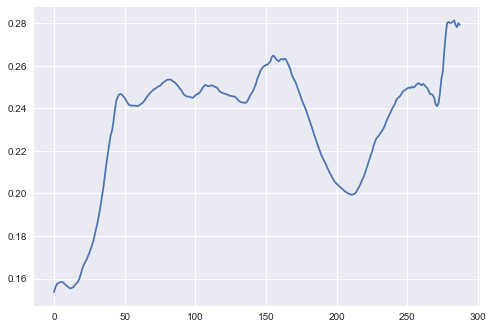

In [83]:
plt.plot(CSTE)


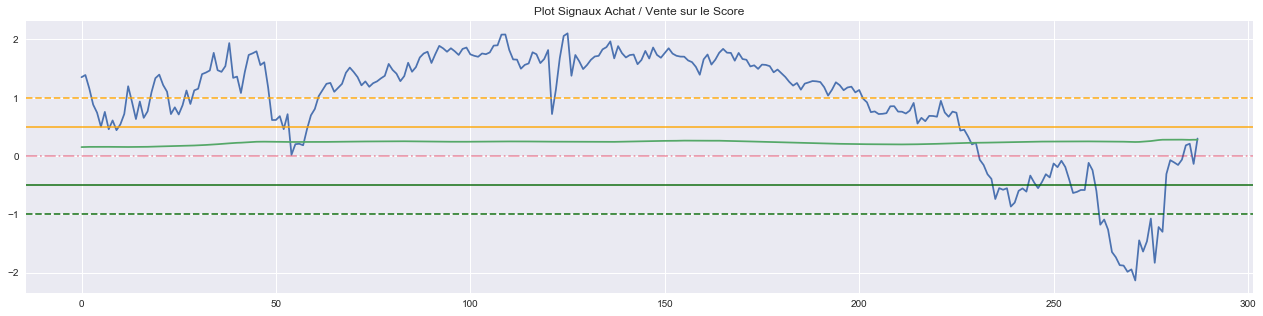

In [91]:
plt.figure(figsize=(22,5))
plt.plot(SCORE,label = 'Score')
plt.plot(CSTE,label='CSTE')
#plt.scatter(x=TIME,y=CL,c='g',marker='x',label='Close Long')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.title('Plot Signaux Achat / Vente sur le Score')
plt.legend((OS,CS,OL,CL),('Open Short','Close Short','Open Long','Close Long'),scatterpoints=1 )


In [34]:
%%time
len(OS),len(OL),len(CS),len(CL),len(SELL1),len(SELL2),len(SELL3),len(BUY1),len(BUY2),len(BUY3),len(NBPOSS),len(NBPOSL),len(SCORE),len(TIME)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


(98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98)

In [62]:
cste

0.2791477630073509

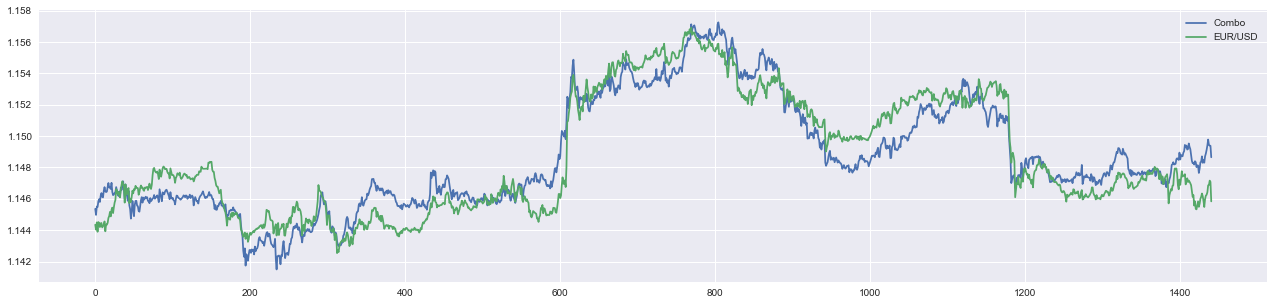

In [117]:

plt.figure(figsize=(22,5))
plt.plot(combo.index,combo,label='Combo')
plt.plot(combo.index,eurusd['Close'],label='EUR/USD')
plt.legend()

In [112]:
len(combo),len(eurusd)

(1441, 1441)

In [113]:
combo

0       1.145358
1       1.144975
2       1.145508
3       1.145477
4       1.145840
          ...   
1436    1.149779
1437    1.149437
1438    1.149398
1439    1.149377
1440    1.148651
Length: 1441, dtype: float64